In [1]:
# import the packages
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

<p>We are using F1 Score as model performance metric because its more appropriate in an imbalanced class problem</p>

<h3>Get the data</h3>

In [2]:
train = pd.read_csv('dataset/train.csv')
train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,97,1,0,0,236.9,107,105,13.40,241.0,120,2,1.97,0,1,0,1
1,28,0,0,0,168.2,87,92,13.74,192.4,112,3,2.73,3,0,1,0
2,120,0,0,0,180.0,80,82,19.06,265.4,91,7,1.27,3,0,1,0
3,80,0,1,33,189.4,109,68,12.64,208.9,119,4,3.02,1,1,1,0
4,100,0,0,0,239.1,96,110,15.31,259.2,112,2,3.78,0,0,0,0


In [3]:
test = pd.read_csv('dataset/test.csv')
test.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,65,0,0,0,111.0,51,84,18.68,202.0,89,14,1.19,1,0,1,0
1,64,0,0,0,206.2,76,76,19.75,251.6,96,2,3.67,1,0,1,0
2,125,0,0,0,126.7,108,90,17.51,247.8,114,7,3.59,1,0,0,0
3,117,0,1,13,207.6,65,77,12.98,232.8,95,3,2.62,1,0,0,0
4,149,0,0,0,175.4,80,127,16.78,188.2,102,2,2.62,2,0,0,0


<p>We will use the test set only for final report on model performance</p>

In [4]:
# split the train data into train-dev set
from sklearn.model_selection import train_test_split

X = train.drop(['churn'], axis=1)
y = train['churn']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

<h3>Random forest (vanilla)</h3>

In [6]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

clf_basic = RandomForestClassifier(n_estimators=100)
clf_basic.fit(X_train, y_train)

y_pred = np.array(clf_basic.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))

F1 score: 0.770


In [7]:
# hyperparameters tuning
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV

clf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['n_estimators'] = [int(x) for x in np.linspace(100, 1000, 10)]
space['max_features'] = ['auto', 'sqrt']
space['max_depth'] = [int(x) for x in np.linspace(10, 110, 11)]
space['min_samples_split'] = [2, 5, 10]
space['min_samples_leaf'] = [1, 2, 4]
space['bootstrap'] = [True, False]

clf_random = RandomizedSearchCV(clf, space, scoring='f1', n_iter=100, cv=cv, verbose=2, n_jobs=-1)
clf_random.fit(X_train, y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='f1', verbose=2)

In [8]:
print('Best hyperparameters: {}'.format(clf_random.best_params_))

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False}


<p>From these results, we should be able to narrow the range of values for each hyperparameter</p>

In [18]:
from sklearn.model_selection import GridSearchCV

space = dict()
space['n_estimators'] = [100, 150, 200, 250, 300]
space['max_features'] = ['auto']
space['max_depth'] = [80, 85, 90, 95, 100]
space['min_samples_split'] = [1, 2, 3]
space['min_samples_leaf'] = [1]
space['bootstrap'] = [False]

clf = RandomForestClassifier()

clf_grid = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [80, 85, 90, 95, 100],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='f1')

In [19]:
y_pred = np.array(clf_grid.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_grid.best_params_))

F1 score: 0.800
Best hyperparameters: {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 250}


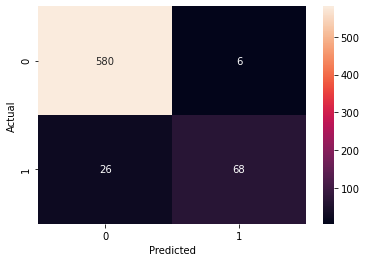

In [11]:
import seaborn as sns

conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>Random forest with SMOTE over-sampling</h3>

In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

clf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['n_estimators'] = [100, 150, 200, 250, 300]
space['max_features'] = ['auto']
space['max_depth'] = [80, 85, 90, 95, 100]
space['min_samples_split'] = [1, 2, 3]
space['min_samples_leaf'] = [1]
space['bootstrap'] = [False]

clf_smote = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_smote.fit(X_train_res, y_train_res)

y_pred = np.array(clf_smote.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_smote.best_params_))

F1 score: 0.707
Best hyperparameters: {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


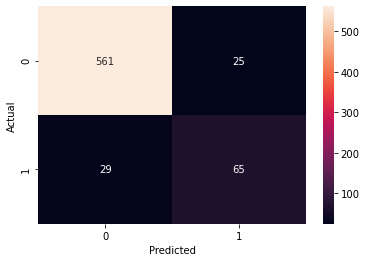

In [13]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>Random forest: combination of SMOTE over-sampling with random undersampling</h3>

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

clf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['n_estimators'] = [100, 150, 200, 250, 300]
space['max_features'] = ['auto']
space['max_depth'] = [80, 85, 90, 95, 100]
space['min_samples_split'] = [1, 2, 3]
space['min_samples_leaf'] = [1]
space['bootstrap'] = [False]

clf_comb = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_comb.fit(X_train_res, y_train_res)

y_pred = np.array(clf_comb.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_comb.best_params_))

F1 score: 0.790
Best hyperparameters: {'bootstrap': False, 'max_depth': 95, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


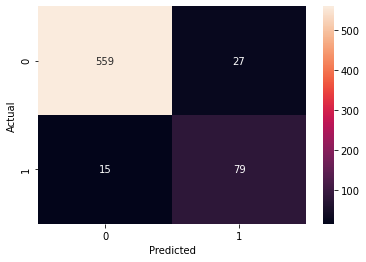

In [15]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<p>It seems like tuned random forest method generates a higher F1 Score than any other methods</p>

<h3>Put all the pieces together</h3>

In [16]:
X_test = test.drop(['churn'], axis=1)
y_test = test['churn']

In [20]:
# clf = RandomForestClassifier()
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# space = dict()
# space['n_estimators'] = [100, 150, 200, 250, 300]
# space['max_features'] = ['auto']
# space['max_depth'] = [80, 85, 90, 95, 100]
# space['min_samples_split'] = [1, 2, 3]
# space['min_samples_leaf'] = [1]
# space['bootstrap'] = [False]

# clf_grid = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_grid.fit(X, y)

y_pred = np.array(clf_grid.predict(X_test))

print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred)))
print('Best hyperparameters: {}'.format(clf_grid.best_params_))

F1 score: 0.798
Best hyperparameters: {'bootstrap': False, 'max_depth': 80, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


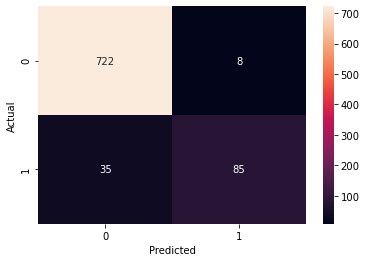

In [21]:
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');